In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline
from edward.models import Bernoulli, Normal

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
#ed.set_seed(42)

def build_toy_dataset(N, noise_std=0.1):
  D = 1
  X = np.linspace(-6, 6, num=N)
  y = np.tanh(X) + np.random.normal(0, noise_std, size=N)
  y[y < 0.5] = 0
  y[y >= 0.5] = 1
  X = (X - 4.0) / 4.0
  X = X.reshape((N, D))
  return X, y


# DATA

In [4]:
N = 40  # number of data points
D = 1  # number of features
X_train, y_train = build_toy_dataset(N)

In [5]:
X_test, y_test = build_toy_dataset(N)

# MODEL

In [6]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=3.0 * tf.ones(D))
b = Normal(loc=tf.zeros([]), scale=3.0 * tf.ones([]))
y = Bernoulli(logits=ed.dot(X, w) + b)

# INFERENCE

In [7]:
qw_loc = tf.Variable(tf.random_normal([D]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D])))
qb_loc = tf.Variable(tf.random_normal([]) + 10)
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc=qw_loc, scale=qw_scale)
qb = Normal(loc=qb_loc, scale=qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.initialize(n_print=10, n_iter=600)
tf.global_variables_initializer().run()

In [8]:
y_post= ed.copy(y, {w: qw, b: qb})

print(X[0].dtype)
print(X_test[0].dtype)
print(y_post[0].dtype)
print(y_test[0].dtype)

In [9]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.55


In [10]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_iter=600)
y_post= ed.copy(y, {w: qw, b: qb})
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

600/600 [100%] ██████████████████████████████ Elapsed: 0s | Loss: 9.666
Mean squared error on test data:
0.025


In [11]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.initialize(n_print=10, n_iter=800)
tf.global_variables_initializer().run()
y_post= ed.copy(y, {w: qw, b: qb})
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

0.55


In [16]:
# CRITICISM
y_rep, y = ed.ppc(
    lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)),
    data={X_test: y_test})

ed.ppc_stat_hist_plot(
    y[0], y_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

In [13]:
inference.n_iter

800

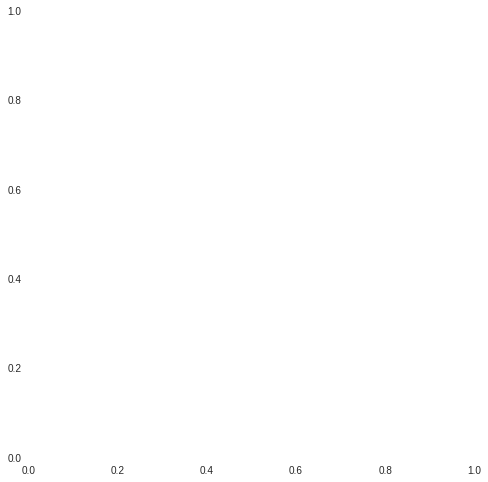

800/800 [100%] ██████████████████████████████ Elapsed: 67s | Loss: 8.861


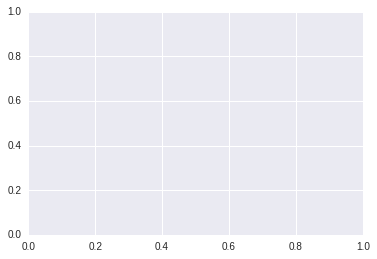

In [14]:
# Set up figure.
fig = plt.figure(figsize=(8, 8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
plt.show(block=False)

# Build samples from inferred posterior.
n_samples = 50
inputs = np.linspace(-5, 3, num=400, dtype=np.float32).reshape((400, 1))
probs = tf.stack([tf.sigmoid(ed.dot(inputs, qw.sample()) + qb.sample())
                  for _ in range(n_samples)])

for t in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)

  if t % inference.n_print == 0:
    outputs = probs.eval()

    # Plot data and functions
    plt.cla()
    ax.plot(X_train[:], y_train, 'bx')
    for s in range(n_samples):
      ax.plot(inputs[:], outputs[s], alpha=0.2)

    ax.set_xlim([-5, 3])
    ax.set_ylim([-0.5, 1.5])
    plt.draw()
    plt.pause(1.0 / 60.0)